<a href="https://colab.research.google.com/github/myazdani/number-guessing/blob/master/number_guessing_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
from torch import optim
import random
import matplotlib.pyplot as plt
import seaborn as sns

### Card number generation 

In [2]:
class NormalCards:
    def __init__(self, mu, sigma, num_cards = 2):
        self.num_cards = 2
        self.mu = mu
        self.sigma = sigma


    def draw_cards(self, flip_coin = False):
        selected_numbers = self.sigma*torch.randn(self.num_cards)+self.mu
        if flip_coin:
            shuffled = torch.randperm(self.num_cards)     
            return selected_numbers[shuffled]
        else:
            return selected_numbers


In [3]:
from scipy.stats import pareto

class ParetoCards:
    def __init__(self, a, b, num_cards = 2):
        self.num_cards = 2
        self.a = a
        self.b = b

    def draw_cards(self, flip_coin = False):
        numpy_pareto = pareto.rvs(self.a, self.b, size = self.num_cards)
        selected_numbers = torch.from_numpy(numpy_pareto.astype(np.float32))
        if flip_coin:
            shuffled = torch.randperm(self.num_cards)     
            return selected_numbers[shuffled]
        else:
            return selected_numbers        


In [4]:
class NumberCards:
    def __init__(self, numbers, num_cards = 2):
        self.num_cards = num_cards
        self.numbers = numbers
        self.iter = 0

    def draw_cards(self, flip_coin = False):
        start_indx, end_indx = self.iter, self.iter+self.num_cards
        if end_indx > len(self.numbers):
            print("out of numbers")
            return None
        
        selected_numbers = torch.from_numpy(self.numbers[start_indx:end_indx])
        self.iter = end_indx
        if flip_coin:
            shuffled = torch.randperm(self.num_cards)     
            return selected_numbers[shuffled]
        else:
            return selected_numbers  

### Agents

In [5]:
class RandomDecision:

    def decision(self, shown_number=0):
        self.prediction = bool(random.randint(0,1))
        return self.prediction

    def update_rule(self, actual):
        pass


class AlwaysTrue:
    def decision(self, shown_number=0):
        self.prediction = True
        return self.prediction

    def update_rule(self, actual):
        pass  


class AlwaysFalse:
    def decision(self, shown_number=0):
        self.prediction = False
        return self.prediction

    def update_rule(self, actual):
        pass          


class OptimalDecision:

    def sigmoid(self, x):
        """
        A numerically stable version of the logistic sigmoid function.
        """
        pos_mask = (x >= 0)
        neg_mask = (x < 0)
        z = np.zeros_like(x)
        z[pos_mask] = np.exp(-x[pos_mask])
        z[neg_mask] = np.exp(x[neg_mask])
        top = np.ones_like(x)
        top[neg_mask] = z[neg_mask]
        return top / (1 + z)

    def decision(self, shown_number=0):
        z = np.random.rand()
        shown_number_squashed = self.sigmoid(shown_number)
        if z <= shown_number_squashed:
            return 0
        else:
            return 1



class LinearDecision:
    # Reference for online logistic regerssion learning rule: 
    # https://courses.cs.washington.edu/courses/cse547/16sp/slides/logistic-SGD.pdf
    def __init__(self, lr = 0.1):
        self.w0 = torch.randn(1)
        self.w1 = torch.randn(1)
        self.sigmoid = nn.Sigmoid()
        self.lr = lr
        self.t = 1

    def z_scale(self, shown_number):
        if self.t == 1:
            self.mu = 0
            self.sigma = 0
        self.mu = ((self.t-1)*self.mu + shown_number)/self.t
        self.sigma = ((self.t-1)*self.sigma + (shown_number-self.mu)**2)/self.t
        if self.t > 1:
            z = (shown_number-self.mu)/self.sigma**.5
        else:
            z = shown_number 
        return z            
    
    def decision(self, shown_number):
        self.shown_number = self.z_scale(shown_number)
        self.prediction = self.sigmoid(self.shown_number*self.w1 + self.w0)
        decision = bool(self.prediction > 0.5)
        return decision

    def update_rule(self, actual):
        delta = actual - self.prediction
        eta = self.lr/(1+np.log(self.t))
        self.w0 = self.w0 + eta*delta
        self.w1 = self.w1 + eta*self.shown_number*delta
        self.t+=1
                    


class LinearMLPDecision:
    def __init__(self, lr = 0.1):
        self.model = nn.Sequential(
            nn.Linear(1, 1), nn.Sigmoid()
        )
        self.lr = lr
        self.t = 1
        self.loss = nn.BCELoss()
        self.sgd = optim.SGD(self.model.parameters(), lr=self.lr)


    def z_scale(self, shown_number):
        if self.t == 1:
            self.mu = 0
            self.sigma = 0
        self.mu = ((self.t-1)*self.mu + shown_number)/self.t
        self.sigma = ((self.t-1)*self.sigma + (shown_number-self.mu)**2)/self.t
        if self.t > 1:
            z = (shown_number-self.mu)/self.sigma**.5
        else:
            z = shown_number 
        return z          


    def decision(self, shown_number):
        self.shown_number = self.z_scale(shown_number)
        self.prediction = self.model(self.shown_number.view(1,1))
        decision = bool(self.prediction.item() > 0.5)
        return decision

    def update_rule(self, actual):
        eta = self.lr/(1+np.log(self.t))
        for g in self.sgd.param_groups:
            g['lr'] = eta
        loss = self.loss(self.prediction, actual.view(1,1))
        self.sgd.zero_grad()
        loss.backward()
        self.sgd.step()
        self.t+=1
        

class MLPDecision:
    def __init__(self, lr = 0.1):
        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(), 
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.lr = lr
        self.t = 1
        self.loss = nn.BCELoss()
        #self.sgd = optim.Adam(self.model.parameters(), lr=self.lr)
        self.sgd = optim.SGD(self.model.parameters(), lr=self.lr)

    def z_scale(self, shown_number):
        if self.t == 1:
            self.mu = 0
            self.sigma = 0
        self.mu = ((self.t-1)*self.mu + shown_number)/self.t
        self.sigma = ((self.t-1)*self.sigma + (shown_number-self.mu)**2)/self.t
        if self.t > 1:
            z = (shown_number-self.mu)/self.sigma**.5
        else:
            z = shown_number 
        return z  

    def decision(self, shown_number):
        self.shown_number = self.z_scale(shown_number)
        self.prediction = self.model(self.shown_number.view(1,1))
        decision = bool(self.prediction.item() > 0.5)
        return decision

    def update_rule(self, actual):
        eta = self.lr/(1+np.log(self.t))
        for g in self.sgd.param_groups:
            g['lr'] = eta
        loss = self.loss(self.prediction, actual.view(1,1))
        self.sgd.zero_grad()
        loss.backward()
        self.sgd.step()
        self.t+=1
                

### Game play

In [6]:
def generate_game(num_iterations, card_generator, agents):
    agent_rewards = {key:[] for key in agents.keys()}

    def get_reward(hidden_number_is_bigger, actual):
        if hidden_number_is_bigger == actual:
            return 1
        else:
            return 0
     
    for i in range(num_iterations):
        selected_numbers = card_generator.draw_cards()
        shown_number = selected_numbers[0]
        hidden_number = selected_numbers[1]

        actual = hidden_number > shown_number

        for agent in agents.keys():
            hidden_number_is_bigger = agents[agent].decision(shown_number)
            reward = get_reward(hidden_number_is_bigger, actual) 
            agent_rewards[agent].append(reward)
            if hasattr(agents[agent], 'update_rule'):
                agents[agent].update_rule(actual.type(torch.float32))     

    return agent_rewards

### helpful plotting functions

In [7]:
def plot_agent_rewards(agent_rewards):
    color = iter(plt.cm.rainbow(np.linspace(0, 1, len(agent_rewards))))

    for i, key in enumerate(agent_rewards.keys()):
        c = next(color)
        plt.plot(oracle_rewards - np.cumsum(agent_rewards[key]), color = c, alpha = .5,
            label = key)
    plt.xlabel("Iteration")
    plt.ylabel("Psuedo regret")
    plt.legend()    

In [8]:
def plot_repeated_agent_rewards(results):
    for j, rewards in enumerate(results):
        color = iter(plt.cm.rainbow(np.linspace(0, 1, len(rewards))))
        for i, key in enumerate(rewards.keys()):
            c = next(color)
            if j == 0:
                plt.plot(oracle_rewards - np.cumsum(rewards[key]), color = c, alpha = .5,
                    label = key)
            else:
                plt.plot(oracle_rewards - np.cumsum(rewards[key]), color = c, alpha = .5)            
    plt.xlabel("Iteration")
    plt.ylabel("Psuedo regret")
    plt.legend()  

In [9]:
def plot_avg_agent_rewards(results):
    all_rewards = {}
    for result in results:
        for key in result.keys():
            if key in all_rewards:
                all_rewards[key].append(result[key])
            else:
                all_rewards[key] = [result[key]]    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, len(rewards))))

    for i, key in enumerate(all_rewards.keys()):
        c = next(color)
        plt.plot(oracle_rewards - np.cumsum(np.mean(all_rewards[key],0)), color = c, 
            label = key)
    plt.legend()        
    plt.xlabel("Iteration")
    plt.ylabel("Psuedo regret")
    plt.legend()  

### Cards drawn from normal distribution

In [10]:
%%time
num_plays = 10000

agents = {"random_agent": RandomDecision(),
          "true_agent":AlwaysTrue(),
          "optimal_agent":OptimalDecision(),
          #"linear_agent":LinearMLPDecision(1e-3),
          "linear_agent":LinearDecision(1e-3),
          "mlp_agent":MLPDecision(1e-3),
          "false_agent":AlwaysFalse(),
          }

normal_cards = NormalCards(mu=100, sigma = 3)

rewards = generate_game(num_iterations=num_plays, 
                        card_generator=normal_cards, 
                        agents=agents
                        )

oracle_rewards = np.cumsum(np.ones_like(range(num_plays)))

CPU times: user 14.7 s, sys: 56.3 ms, total: 14.7 s
Wall time: 19.8 s


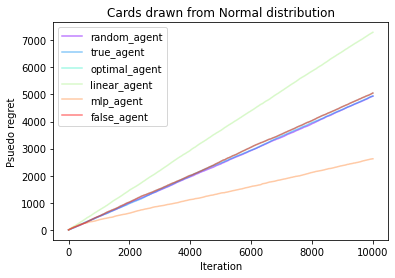

In [11]:
plot_agent_rewards(rewards)
plt.title("Cards drawn from Normal distribution");

In [12]:
%%time
num_plays = 10000
results = []
for _ in range(10):
    agents = {"random_agent": RandomDecision(),
            "true_agent":AlwaysTrue(),
            "optimal_agent":OptimalDecision(),
            #"linear_agent":LinearMLPDecision(1e-3),
            "linear_agent":LinearDecision(1e-3),
            "mlp_agent":MLPDecision(1e-3),
            "false_agent":AlwaysFalse(),            
            }

    normal_cards = NormalCards(mu=100, sigma = 3)

    rewards = generate_game(num_iterations=num_plays, 
                            card_generator=normal_cards, 
                            agents=agents
                        )

    results.append(rewards)

oracle_rewards = np.cumsum(np.ones_like(range(num_plays)))

CPU times: user 1min 48s, sys: 228 ms, total: 1min 48s
Wall time: 1min 50s


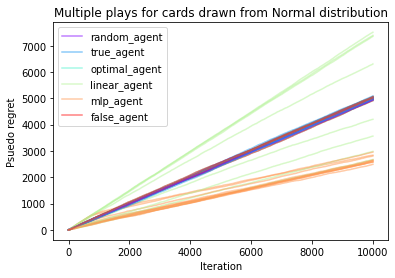

In [13]:
plot_repeated_agent_rewards(results)
plt.title("Multiple plays for cards drawn from Normal distribution");

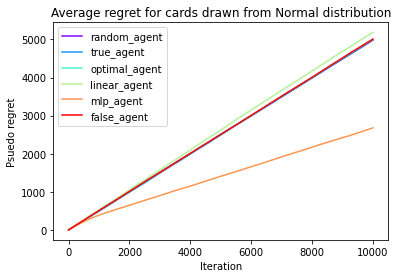

In [14]:
plot_avg_agent_rewards(results)
plt.title("Average regret for cards drawn from Normal distribution");

### Cards drawn from Pareto

In [15]:
%%time
num_plays = 10000


agents = {"random_agent": RandomDecision(),
          "true_agent":AlwaysTrue(),
          "optimal_agent":OptimalDecision(),
          "linear_agent":LinearMLPDecision(1e-3),
          #"linear_agent":LinearDecision(1e-3),
          "mlp_agent":MLPDecision(1e-3),
          "false_agent":AlwaysFalse(),
          }

pareto_cards = ParetoCards(a=4.32, b =3.18)

rewards = generate_game(num_iterations=num_plays, 
                        card_generator=pareto_cards, 
                        agents=agents
                        )

oracle_rewards = np.cumsum(np.ones_like(range(num_plays)))

CPU times: user 14.8 s, sys: 38.8 ms, total: 14.8 s
Wall time: 14.9 s


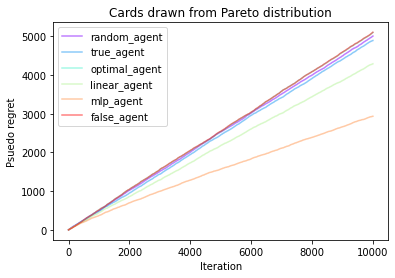

In [16]:
plot_agent_rewards(rewards)
plt.title("Cards drawn from Pareto distribution");

In [17]:
%%time
num_plays = 10000
results = []
for _ in range(10):
    agents = {"random_agent": RandomDecision(),
            "true_agent":AlwaysTrue(),
            "optimal_agent":OptimalDecision(),
            #"linear_agent":LinearMLPDecision(1e-3),
            "linear_agent":LinearDecision(1e-3),
            "mlp_agent":MLPDecision(1e-3),
            "false_agent":AlwaysFalse(),
            }

    pareto_cards = ParetoCards(a=4.32, b =3.18)

    rewards = generate_game(num_iterations=num_plays, 
                            card_generator=pareto_cards, 
                            agents=agents
                        )

    results.append(rewards)

oracle_rewards = np.cumsum(np.ones_like(range(num_plays)))

CPU times: user 2min 4s, sys: 273 ms, total: 2min 4s
Wall time: 2min 5s


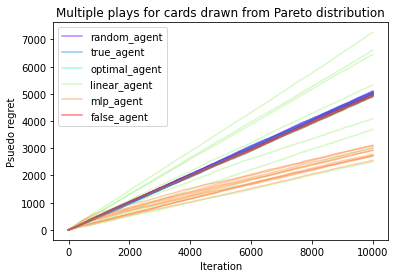

In [18]:
plot_repeated_agent_rewards(results)
plt.title("Multiple plays for cards drawn from Pareto distribution");

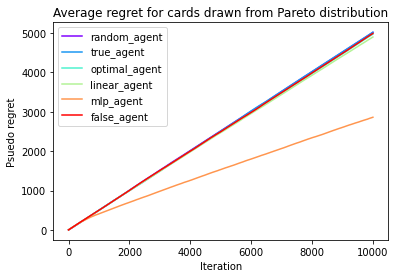

In [19]:
plot_avg_agent_rewards(results)
plt.title("Average regret for cards drawn from Pareto distribution");

### S&P 500 card numbers

In [20]:
import pandas as pd
url = 'https://raw.githubusercontent.com/datasets/s-and-p-500/master/data/data.csv'
df = pd.read_csv(url)


In [21]:
from sklearn.utils import shuffle
#numbers = shuffle(df['Real Price'].values.astype(np.float32))
numbers = df['Real Price'].values.astype(np.float32)

In [22]:
%%time
num_plays = len(numbers)//2


agents = {"random_agent": RandomDecision(),
          "true_agent":AlwaysTrue(),
          "optimal_agent":OptimalDecision(),
          "linear_agent":LinearMLPDecision(1e-3),
          #"linear_agent":LinearDecision(1e-3),
          "mlp_agent":MLPDecision(1e-3),
          "false_agent":AlwaysFalse(),          
          }

s_and_p_500 = NumberCards(numbers=numbers)

rewards = generate_game(num_iterations=num_plays, 
                        card_generator=s_and_p_500, 
                        agents=agents
                        )

oracle_rewards = np.cumsum(np.ones_like(range(num_plays)))

CPU times: user 1.29 s, sys: 7.99 ms, total: 1.29 s
Wall time: 1.31 s


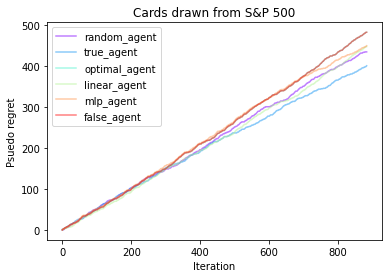

In [23]:
plot_agent_rewards(rewards)
plt.title("Cards drawn from S&P 500");

In [24]:
%%time
num_plays = len(numbers)//2
results = []
for _ in range(10):
    agents = {"random_agent": RandomDecision(),
            "true_agent":AlwaysTrue(),
            "optimal_agent":OptimalDecision(),
            #"linear_agent":LinearMLPDecision(1e-3),
            "linear_agent":LinearDecision(1e-3),
            "mlp_agent":MLPDecision(1e-3),
            "false_agent":AlwaysFalse(),            
            }

    s_and_p_500 = NumberCards(numbers=numbers)

    rewards = generate_game(num_iterations=num_plays, 
                            card_generator=s_and_p_500, 
                            agents=agents
                        )

    results.append(rewards)

oracle_rewards = np.cumsum(np.ones_like(range(num_plays)))

CPU times: user 9.8 s, sys: 29.8 ms, total: 9.83 s
Wall time: 9.88 s


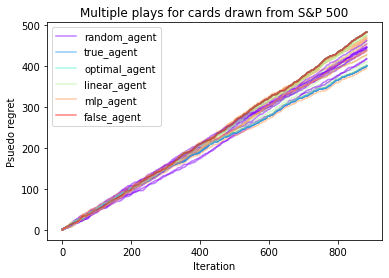

In [25]:
plot_repeated_agent_rewards(results)
plt.title("Multiple plays for cards drawn from S&P 500");

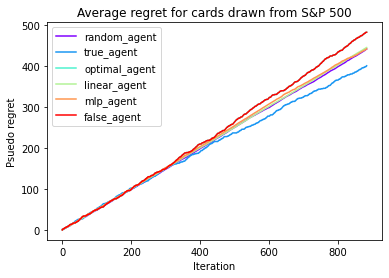

In [26]:
plot_avg_agent_rewards(results)
plt.title("Average regret for cards drawn from S&P 500");

# Old stuff
Reference for online logistic regerssion learning rule: https://courses.cs.washington.edu/courses/cse547/16sp/slides/logistic-SGD.pdf



In [ ]:
import torch
from torch import nn
import numpy as np
from torch import optim


In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class RandomDecision:

    def decision(self, shown_number=0):
        self.prediction = bool(random.randint(0,1))
        return self.prediction

    def update_rule(self, actual):
        pass


class AlwaysTrue:

    def decision(self, shown_number=0):
        self.prediction = True
        return self.prediction

    def update_rule(self, actual):
        pass  


class OptimalDecision:

    def sigmoid(self, x):
        """
        A numerically stable version of the logistic sigmoid function.
        """
        pos_mask = (x >= 0)
        neg_mask = (x < 0)
        z = np.zeros_like(x)
        z[pos_mask] = np.exp(-x[pos_mask])
        z[neg_mask] = np.exp(x[neg_mask])
        top = np.ones_like(x)
        top[neg_mask] = z[neg_mask]
        return top / (1 + z)

    def decision(self, shown_number=0):
        z = np.random.rand()
        shown_number_squashed = self.sigmoid(shown_number)
        if z <= shown_number_squashed:
            return 0
        else:
            return 1


In [ ]:
class LinearDecision:
    def __init__(self, lr = 0.1):
        self.w0 = torch.randn(1)
        self.w1 = torch.randn(1)
        self.sigmoid = nn.Sigmoid()
        self.lr = lr
        self.t = 1
    
    def decision(self, shown_number):
        self.shown_number = shown_number
        self.prediction = self.sigmoid(self.shown_number*self.w1 + self.w0)
        decision = bool(self.prediction > 0.5)
        return decision

    def update_rule(self, actual):
        delta = actual - self.prediction
        eta = self.lr/(1+np.log(self.t))
        self.w0 = self.w0 + eta*delta
        self.w1 = self.w1 + eta*self.shown_number*delta
        self.t+=1
        

In [ ]:
class LinearMLPDecision:
    def __init__(self, lr = 0.1):
        self.model = nn.Sequential(
            nn.Linear(1, 1), nn.Sigmoid()
        )
        self.lr = lr
        self.t = 1
        self.loss = nn.BCELoss()
        self.sgd = optim.SGD(self.model.parameters(), lr=self.lr)


    def decision(self, shown_number):
        self.shown_number = shown_number
        self.prediction = self.model(shown_number.view(1,1))
        decision = bool(self.prediction.item() > 0.5)
        return decision

    def update_rule(self, actual):
        eta = self.lr/(1+np.log(self.t))
        for g in self.sgd.param_groups:
            g['lr'] = eta
        loss = self.loss(self.prediction, actual.view(1,1))
        self.sgd.zero_grad()
        loss.backward()
        self.sgd.step()
        self.t+=1
        

In [ ]:
class MLPDecision:
    def __init__(self, lr = 0.1):
        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(), 
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.lr = lr
        self.t = 1
        self.loss = nn.BCELoss()
        #self.sgd = optim.Adam(self.model.parameters(), lr=self.lr)
        self.sgd = optim.SGD(self.model.parameters(), lr=self.lr)


    def decision(self, shown_number):
        self.shown_number = shown_number
        self.prediction = self.model(shown_number.view(1,1))
        decision = bool(self.prediction.item() > 0.5)
        return decision

    def update_rule(self, actual):
        eta = self.lr/(1+np.log(self.t))
        for g in self.sgd.param_groups:
            g['lr'] = eta
        loss = self.loss(self.prediction, actual.view(1,1))
        self.sgd.zero_grad()
        loss.backward()
        self.sgd.step()
        self.t+=1
        

### normal distribution

In [ ]:



    


all_correct_rewards = np.cumsum(np.ones_like(linear_rewards))

In [ ]:
def generate_normal_run(num_iterations = 10000):
    random_agent = RandomDecision()
    true_agent = AlwaysTrue()
    optimal_agent = OptimalDecision()
    linear_agent = LinearMLPDecision(1e-3)
    #linear_agent = LinearDecision(1e-3)
    mlp_agent = MLPDecision(1e-3)
    random_rewards = []
    always_true_rewards = []
    linear_rewards = []
    mlp_rewards = []
    optimal_rewards = []


    def get_reward(hidden_number_is_bigger, actual):
        if hidden_number_is_bigger == actual:
            return 1
        else:
            return 0

    mu = 0
    sigma = 0
    for i in range(10000):
        selected_numbers = 3*torch.randn(2)+1000
        coin_flip = random.randint(0,1)
        shown_number = selected_numbers[coin_flip]
        hidden_number = selected_numbers[~coin_flip]

        actual = hidden_number > shown_number

        ## naive strategy
        hidden_number_is_bigger = random_agent.decision(shown_number)
        random_rewards.append(get_reward(hidden_number_is_bigger, actual))

        ## always return true strategy
        hidden_number_is_bigger = true_agent.decision(shown_number)
        always_true_rewards.append(get_reward(hidden_number_is_bigger, actual))    

        ## optimal strategy
        hidden_number_is_bigger = optimal_agent.decision(shown_number)
        optimal_rewards.append(get_reward(hidden_number_is_bigger, actual))          

        # linear strategy
        mu = (i*mu + shown_number)/(i+1)
        sigma = (i*sigma + (shown_number-mu)**2)/(i+1)
        if i > 2:
            z = (shown_number-mu)/sigma**.5
        else:
            z = shown_number
        hidden_number_is_bigger = linear_agent.decision(z)
        linear_agent.update_rule(actual.type(torch.float32))    
        linear_rewards.append(get_reward(hidden_number_is_bigger, actual))

        # mlp strategy
        hidden_number_is_bigger = mlp_agent.decision(z)
        mlp_agent.update_rule(actual.type(torch.float32))    
        mlp_rewards.append(get_reward(hidden_number_is_bigger, actual))  



    return linear_rewards, random_rewards, mlp_rewards, always_true_rewards, optimal_rewards

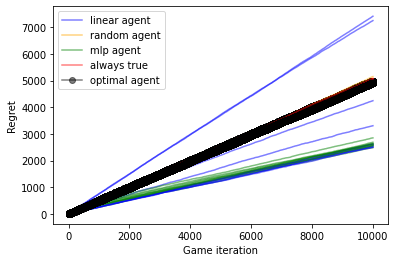

In [ ]:
for i in range(10):
    linear_rewards, random_rewards, mlp_rewards, always_true_rewards, optimal_rewards = generate_normal_run()    
    if i == 0:
        plt.plot(all_correct_rewards - np.cumsum(np.array(linear_rewards)), color = 'b', alpha = .5,
                label = "linear agent")
        plt.plot(all_correct_rewards- np.cumsum(np.array(random_rewards)), color = 'orange', alpha = .5,
                label = "random agent")
        plt.plot(all_correct_rewards- np.cumsum(np.array(mlp_rewards)), color = 'green', alpha = .5,
                label = "mlp agent")
        plt.plot(all_correct_rewards- np.cumsum(np.array(always_true_rewards)), color = 'red', alpha = .5,
                label = "always true")
        plt.plot(all_correct_rewards- np.cumsum(np.array(optimal_rewards)), color = 'k', alpha = .5, marker = 'o',
                label = "optimal agent")        
    else:
        plt.plot(all_correct_rewards - np.cumsum(np.array(linear_rewards)), color = 'b', alpha = .5,)
        plt.plot(all_correct_rewards- np.cumsum(np.array(random_rewards)), color = 'orange', alpha = .5,)
        plt.plot(all_correct_rewards- np.cumsum(np.array(mlp_rewards)), color = 'green', alpha = .5,)
        plt.plot(all_correct_rewards- np.cumsum(np.array(always_true_rewards)), color = 'red', alpha = .5,)
        plt.plot(all_correct_rewards- np.cumsum(np.array(optimal_rewards)), color = 'k', alpha = .5, marker = 'o')           
plt.xlabel("Game iteration")
plt.ylabel("Regret")
plt.legend();

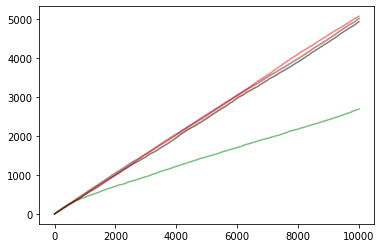

In [ ]:
        plt.plot(all_correct_rewards - np.cumsum(np.array(linear_rewards)), color = 'b', alpha = .5,
                label = "linear agent")
        plt.plot(all_correct_rewards- np.cumsum(np.array(random_rewards)), color = 'orange', alpha = .5,
                label = "random agent")
        plt.plot(all_correct_rewards- np.cumsum(np.array(mlp_rewards)), color = 'green', alpha = .5,
                label = "mlp agent")
        plt.plot(all_correct_rewards- np.cumsum(np.array(always_true_rewards)), color = 'red', alpha = .5,
                label = "always true")
        plt.plot(all_correct_rewards- np.cumsum(np.array(optimal_rewards)), color = 'k', alpha = .5,
                label = "optimal agent")  

### heavy tail distribution

In [ ]:
from scipy.stats import pareto

In [ ]:
optimal_rewards = np.cumsum(np.ones_like(linear_rewards))


def generate_pareto_run(num_iterations = 10000):
    random_agent = RandomDecision()
    true_agent = AlwaysTrue()
    linear_agent = LinearMLPDecision(1e-3)
    #linear_agent = LinearDecision(1e-3)
    mlp_agent = MLPDecision(1e-3)
    random_rewards = []
    always_true_rewards = []
    linear_rewards = []
    mlp_rewards = []


    def get_reward(hidden_number_is_bigger, actual):
        if hidden_number_is_bigger == actual:
            return 1
        else:
            return 0

    mu = 0
    sigma = 0
    for i in range(10000):
        a, b = 4.32, 3.18    
        selected_numbers = torch.from_numpy(pareto.rvs(a, b, size = 2).astype(np.float32))
        coin_flip = random.randint(0,1)
        shown_number = selected_numbers[coin_flip]
        hidden_number = selected_numbers[~coin_flip]

        actual = hidden_number > shown_number

        ## naive strategy
        hidden_number_is_bigger = random_agent.decision(shown_number)
        random_rewards.append(get_reward(hidden_number_is_bigger, actual))

        ## always return true strategy
        hidden_number_is_bigger = true_agent.decision(shown_number)
        always_true_rewards.append(get_reward(hidden_number_is_bigger, actual))    

        # linear strategy
        mu = (i*mu + shown_number)/(i+1)
        sigma = (i*sigma + (shown_number-mu)**2)/(i+1)
        if i > 2:
            z = (shown_number-mu)/sigma**.5
        else:
            z = shown_number
        hidden_number_is_bigger = linear_agent.decision(z)
        linear_agent.update_rule(actual.type(torch.float32))    
        linear_rewards.append(get_reward(hidden_number_is_bigger, actual))

        # mlp strategy
        hidden_number_is_bigger = mlp_agent.decision(z)
        mlp_agent.update_rule(actual.type(torch.float32))    
        mlp_rewards.append(get_reward(hidden_number_is_bigger, actual))  



    return linear_rewards, random_rewards, mlp_rewards, always_true_rewards

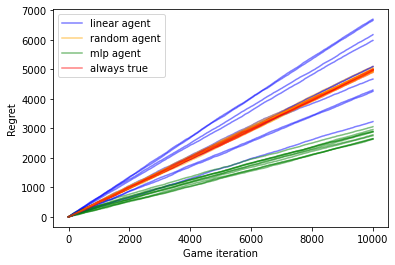

In [ ]:
for i in range(10):
    linear_rewards, random_rewards, mlp_rewards, always_true_rewards = generate_pareto_run()    
    if i == 0:
        plt.plot(optimal_rewards - np.cumsum(np.array(linear_rewards)), color = 'b', alpha = .5,
                label = "linear agent")
        plt.plot(optimal_rewards- np.cumsum(np.array(random_rewards)), color = 'orange', alpha = .5,
                label = "random agent")
        plt.plot(optimal_rewards- np.cumsum(np.array(mlp_rewards)), color = 'green', alpha = .5,
                label = "mlp agent")
        plt.plot(optimal_rewards- np.cumsum(np.array(always_true_rewards)), color = 'red', alpha = .5,
                label = "always true")
    else:
        plt.plot(optimal_rewards - np.cumsum(np.array(linear_rewards)), color = 'b', alpha = .5,)
        plt.plot(optimal_rewards- np.cumsum(np.array(random_rewards)), color = 'orange', alpha = .5,)
        plt.plot(optimal_rewards- np.cumsum(np.array(mlp_rewards)), color = 'green', alpha = .5,)
        plt.plot(optimal_rewards- np.cumsum(np.array(always_true_rewards)), color = 'red', alpha = .5,)
plt.xlabel("Game iteration")
plt.ylabel("Regret")
plt.legend();

### S&P 500

In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/datasets/s-and-p-500/master/data/data.csv'
df = pd.read_csv(url)

,Date,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10
1763,2017-12-01,2664.34,48.93,109.88,246.52,2.40,2700.13,49.59,111.36,32.09
1764,2018-01-01,2789.80,49.29,NaN,247.87,2.58,2811.96,49.68,NaN,33.31
1765,2018-02-01,2705.16,49.64,NaN,248.99,2.86,2714.34,49.81,NaN,32.12
1766,2018-03-01,2702.77,50.00,NaN,249.55,2.84,2705.82,50.06,NaN,31.99
1767,2018-04-01,2642.19,NaN,NaN,249.84,2.80,2642.19,NaN,NaN,31.19


In [ ]:
#numbers = np.hstack((df['Real Price'].values, df['SP500'].values)).astype(np.float32)
numbers = df['Real Price'].values.astype(np.float32)

In [ ]:
def generate_game(raw_numbers):
    random_agent = RandomDecision()
    true_agent = AlwaysTrue()
    optimal_agent = OptimalDecision()
    linear_agent = LinearMLPDecision(1e-3)
    #linear_agent = LinearDecision(1e-3)
    mlp_agent = MLPDecision(1e-3)
    random_rewards = []
    always_true_rewards = []
    linear_rewards = []
    mlp_rewards = []
    optimal_rewards = []


    def get_reward(hidden_number_is_bigger, actual):
        if hidden_number_is_bigger == actual:
            return 1
        else:
            return 0

    mu = 0
    sigma = 0
    for i in range(0, len(raw_numbers),2):
        selected_numbers = torch.from_numpy(raw_numbers[i:i+2])
        coin_flip = random.randint(0,1)
        shown_number = selected_numbers[coin_flip]
        hidden_number = selected_numbers[~coin_flip]

        actual = hidden_number > shown_number

        ## naive strategy
        hidden_number_is_bigger = random_agent.decision(shown_number)
        random_rewards.append(get_reward(hidden_number_is_bigger, actual))

        ## always return true strategy
        hidden_number_is_bigger = true_agent.decision(shown_number)
        always_true_rewards.append(get_reward(hidden_number_is_bigger, actual))   


        ## optimal strategy
        hidden_number_is_bigger = optimal_agent.decision(shown_number)
        optimal_rewards.append(get_reward(hidden_number_is_bigger, actual))             

        # linear strategy
        mu = (i*mu + shown_number)/(i+1)
        sigma = (i*sigma + (shown_number-mu)**2)/(i+1)
        if i > 2:
            z = (shown_number-mu)/sigma**.5
        else:
            z = shown_number
        hidden_number_is_bigger = linear_agent.decision(z)
        linear_agent.update_rule(actual.type(torch.float32))    
        linear_rewards.append(get_reward(hidden_number_is_bigger, actual))

        # mlp strategy
        hidden_number_is_bigger = mlp_agent.decision(z)
        mlp_agent.update_rule(actual.type(torch.float32))    
        mlp_rewards.append(get_reward(hidden_number_is_bigger, actual))  



    return linear_rewards, random_rewards, mlp_rewards, always_true_rewards, optimal_rewards

In [ ]:
from sklearn.utils import shuffle

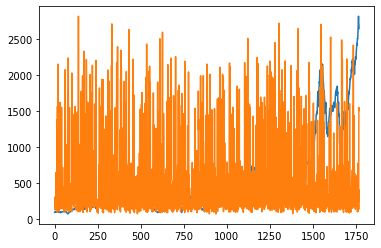

In [ ]:
plt.plot(numbers)
plt.plot(shuffle(numbers))

In [ ]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class GameRewards:
    linear_rewards: List = field(default_factory=list)
    random_rewards: List = field(default_factory=list)
    mlp_rewards: List = field(default_factory=list)
    always_true_rewards: List = field(default_factory=list)
    optimal_rewards: List = field(default_factory=list)

In [ ]:
%%time
a, b = 4.32, 3.18    
numbers = pareto.rvs(a, b, size = 10000).astype(np.float32)


all_correct_rewards = np.cumsum(np.ones_like(numbers[:len(numbers)//2]))

results = GameRewards()
for _ in range(10):
    numbers = pareto.rvs(a, b, size = 10000).astype(np.float32)
    linear_rewards, random_rewards, mlp_rewards, always_true_rewards, optimal_rewards = generate_game(numbers)
    results.linear_rewards.append(linear_rewards)
    results.always_true_rewards.append(always_true_rewards)
    results.mlp_rewards.append(mlp_rewards)
    results.random_rewards.append(random_rewards)
    results.optimal_rewards.append(optimal_rewards)

CPU times: user 54.4 s, sys: 99.6 ms, total: 54.5 s
Wall time: 55.7 s


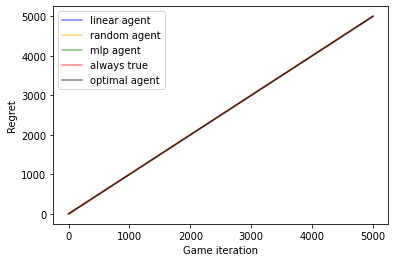

In [ ]:
plt.plot(all_correct_rewards - np.mean(np.cumsum(results.linear_rewards,axis=0), axis = 0), color = 'b', alpha = .5,
        label = "linear agent")
plt.plot(all_correct_rewards- np.mean(np.cumsum(results.random_rewards, axis = 0), axis = 0), color = 'orange', alpha = .5,
        label = "random agent")
plt.plot(all_correct_rewards- np.mean(np.cumsum(results.mlp_rewards, axis = 0), axis = 0), color = 'green', alpha = .5,
        label = "mlp agent")
plt.plot(all_correct_rewards- np.mean(np.cumsum(results.always_true_rewards,axis=0), axis = 0), color = 'red', alpha = .5,
        label = "always true")
plt.plot(all_correct_rewards- np.mean(np.cumsum(results.optimal_rewards, axis = 0), axis = 0), color = 'k', alpha = .5, 
        label = "optimal agent")   
#plt.fill_between(range(len(all_correct_rewards)), (y-ci), (y+ci), color='b', alpha=.1)            
plt.xlabel("Game iteration")
plt.ylabel("Regret")
plt.legend();

In [ ]:
np.mean(np.cumsum(results.optimal_rewards, axis = 0),axis = 0).shape

(884,)

## misc

In [ ]:
torch.tensor(5)

tensor(5)

In [ ]:
import matplotlib.pyplot as plt

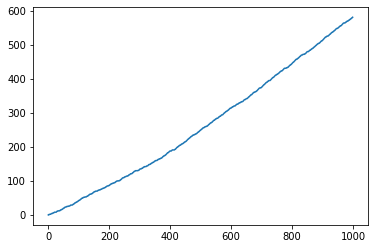

In [ ]:
plt.plot(np.cumsum(np.array(rewards)))

In [ ]:
naive_agent = NaiveDecision()
#linear_agent = LinearMLPDecision(0.9)
linear_agent = LinearDecision(0.9)
mlp_agent = MLPDecision(1e-3)
naive_rewards = []
linear_rewards = []
mlp_rewards = []


def get_reward(hidden_number_is_bigger, actual):
    if hidden_number_is_bigger == actual:
        return 1
    else:
        return 0


In [ ]:
shown_number = 7000



In [ ]:
## naive strategy
hidden_number_is_bigger = naive_agent.decision(shown_number)
naive_rewards.append(get_reward(hidden_number_is_bigger, actual))

In [ ]:
hidden_number_is_bigger = linear_agent.decision(shown_number)
hidden_number_is_bigger

False

In [ ]:
actual = torch.tensor(8) > torch.tensor(shown_number)
linear_agent.update_rule(actual.type(torch.float32))    
linear_rewards.append(get_reward(hidden_number_is_bigger, actual))

In [ ]:
linear_rewards

[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]

In [ ]:
naive_rewards = [random.randint(0,1) for _ in range(len(linear_rewards))]

In [ ]:
optimal_rewards = np.cumsum(np.ones_like(linear_rewards))

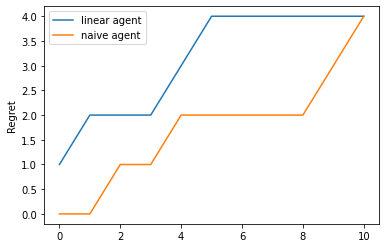

In [ ]:
plt.plot(optimal_rewards - np.cumsum(np.array(linear_rewards)), label = "linear agent")
naive_rewards = [random.randint(0,1) for _ in range(len(linear_rewards))]
plt.plot(optimal_rewards- np.cumsum(np.array(naive_rewards)), label = "naive agent")
#plt.plot(-optimal_rewards, label = "optimal")
#plt.plot(optimal_rewards- np.cumsum(np.array(mlp_rewards)), label = "mlp agent")
plt.ylabel("Regret")
plt.legend();

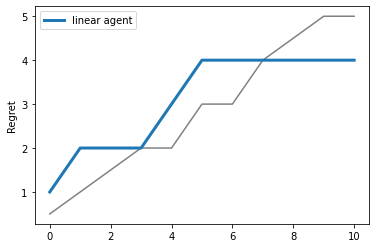

In [ ]:


guesses = []
for _ in range(1000):
    naive_rewards = [random.randint(0,1) for _ in range(len(linear_rewards))]
    guesses.append(optimal_rewards- np.cumsum(np.array(naive_rewards)))
plt.plot(np.median(np.array(guesses),0), color = 'gray')
plt.plot(optimal_rewards - np.cumsum(np.array(linear_rewards)), label = "linear agent", lw = 3)
#plt.plot(optimal_rewards- np.cumsum(np.array(mlp_rewards)), label = "mlp agent")
plt.ylabel("Regret")
plt.legend();

In [ ]:
np.array(guesses)

(1000, 11)

In [ ]:
|





#selected_numbers = 3*torch.randn(2)+5
selected_numbers = torch.from_numpy(datasets.make_blobs(n_samples=1,)[0]).type(torch.float32)[0]
coin_flip = random.randint(0,1)
shown_number = selected_numbers[coin_flip]
hidden_number = selected_numbers[~coin_flip]

actual = hidden_number > shown_number

## naive strategy
hidden_number_is_bigger = naive_agent.decision(shown_number)
naive_rewards.append(get_reward(hidden_number_is_bigger, actual))

# linear strategy
hidden_number_is_bigger = linear_agent.decision(shown_number)
linear_agent.update_rule(actual.type(torch.float32))    
linear_rewards.append(get_reward(hidden_number_is_bigger, actual))

# mlp strategy
hidden_number_is_bigger = mlp_agent.decision(shown_number)
mlp_agent.update_rule(actual.type(torch.float32))    
mlp_rewards.append(get_reward(hidden_number_is_bigger, actual))


    


optimal_rewards = np.cumsum(np.ones_like(linear_rewards))